## DATA used in CCN2025 paper

In [2]:
import numpy as np
import xarray as xr
from src.EEGModalNet.preprocessing.preprocessing import preprocess_data
from mne.time_frequency import psd_array_welch
from matplotlib import pyplot as plt
from scipy.signal import butter, sosfiltfilt

/opt/homebrew/Caskroom/miniforge/base/envs/EEGModalNet/lib/python3.11/site-packages/mne/externals/tempita/__init__.py:35: DeprecationWarning: 'cgi' is deprecated and slated for removal in Python 3.13
  import cgi


### Preprocessing

In [ ]:
channels = ['O1', 'O2', 'F1', 'F2', 'C1', 'C2', 'P1', 'P2']
data_path = 'data/LEMON_data/eeg_eo_ec.nc5'
xarray = xr.open_dataset(data_path, engine='h5netcdf')

subjects = xarray.subject.to_numpy()
x = xarray['eye_closed'].sel(channel=channels).to_numpy()

data = preprocess_data(x, sampling_rate=128)

# create a dataaraay and save
data_path = 'data/LEMON_data/EC_8_channels_processed.nc5'
xarray = xr.DataArray(data, dims=['subject', 'channel', 'time'])
xarray = xarray.assign_coords(subject=subjects, channel=channels)

# xarray.to_netcdf(data_path, engine='h5netcdf')

### Inspect the PSD of the preprocessed data 

In [24]:
# open preprocessed data
data_path = 'data/LEMON_data/EC_8_channels_processed.nc5'
channels = ['O1', 'O2', 'F1', 'F2', 'C1', 'C2', 'P1', 'P2']
xarray = xr.open_dataarray(data_path, engine='h5netcdf')
x = xarray.to_numpy()

# apply butterworth filter
sos = butter(4, 1, btype='high', fs=128, output='sos')
x_filtered = sosfiltfilt(sos, x, axis=2)

In [41]:
psd, freq = psd_array_welch(x_filtered, sfreq=128, n_fft=256, n_per_seg=256, n_overlap=128, average='mean')

Effective window size : 2.000 (s)


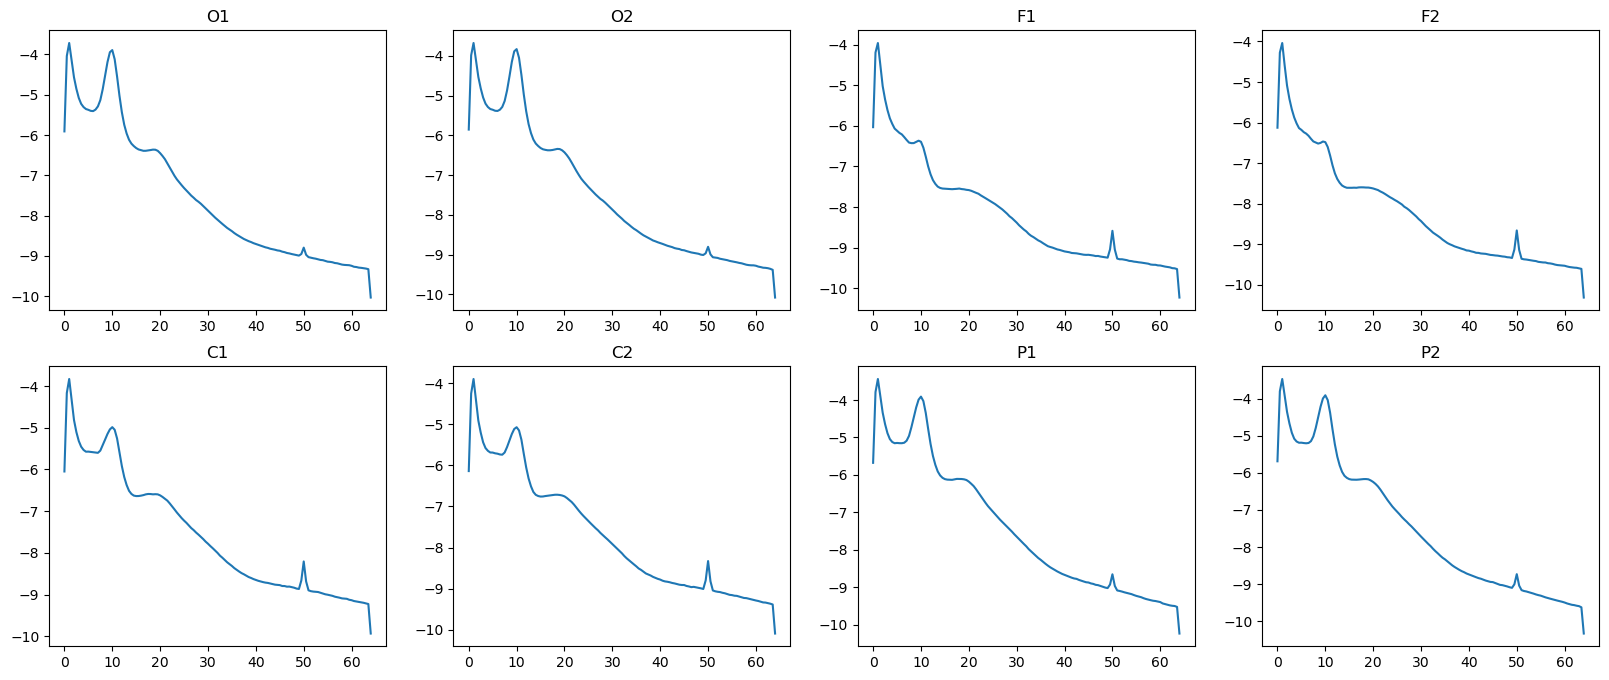

In [40]:
fig, axes = plt.subplots(2, 4, figsize=(20, 8))
for i in range(x.shape[1]):
    ax = axes[i // 4, i % 4]
    ax.plot(freq, np.log(psd[:, i, :]).mean(axis=0))
    ax.set_title(channels[i])